# Compute correlation function with error bars using log-normal mocks

In [13]:
import time
from tqdm.notebook import tqdm

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction
from mockfactory import EulerianLinearMock, LagrangianLinearMock, RandomBoxCatalog, setup_logging
from iminuit import Minuit

import catalog_data
import density_split

## Data and output directories

In [14]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [15]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

## Generate log-normal mock

In [4]:
def generate_mock(nmesh, boxsize, boxcenter, seed, cosmology, nbar, z, bias, rsd=False, los=None, f=None, save=False, output_dir='', name='mock'):
    pklin = cosmology.get_fourier().pk_interpolator().to_1d(z)
    
    # unitary_amplitude forces amplitude to 1
    mock = LagrangianLinearMock(pklin, nmesh=nmesh, boxsize=boxsize, boxcenter=boxcenter, seed=seed, unitary_amplitude=False)

    # this is Lagrangian bias, Eulerian bias - 1
    mock.set_real_delta_field(bias=bias - 1)
    mock.set_analytic_selection_function(nbar=nbar)
    mock.poisson_sample(seed=seed+1)
    #mock.set_rsd(f=f, los=los)
    data = mock.to_catalog()
    
    # Create Data instance
    positions = data['Position'].T % boxsize

    mock_catalog = catalog_data.Data(positions, z, boxsize, boxcenter, name=name)
    
    if save:
        mock_catalog.save(output_dir+name)
        
    return mock_catalog

In [12]:
t1 = time.time()
mock_catalog = generate_mock(nmesh=catalog.boxsize/2, boxsize=catalog.boxsize, boxcenter=catalog.boxcenter, seed=0, 
                             cosmology=fiducial.AbacusSummitBase(), nbar=catalog.size/catalog.boxsize**3, 
                             z=catalog.redshift, bias=bias)
t2 = time.time()

print('Execution time: {}s'.format(t2-t1))

Execution time: 47.3206045627594s


## Split densities

In [6]:
cellsize = 20
resampler = 'tsc'

def split_density(catalog, cellsize, resampler, nsplits, save=False, output_dir=''):
    catalog_density = density_split.DensitySplit(catalog)
    catalog_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=False)
    catalog_density.split_density(2)
    
    if save:
        catalog_density.save(output_dir+catalog.name+'_density')
        
    return catalog_density

In [8]:
t1 = time.time()
mock_density = split_density(mock_catalog, cellsize, resampler, nsplits=2, save=False, output_dir=output_dir)
t2 = time.time()
print('Execution time: {}s'.format(t2-t1))

catalog_density = split_density(catalog, cellsize, resampler, nsplits=2, save=False, output_dir=output_dir)
#catalog_density = density_split.DensitySplit.load(output_dir+catalog_name+'_density_split.npy')

Execution time: 1.6733970642089844s


## Compute cross-correlation function on split densities

In [9]:
def compute_densitySplit_CCF(data_density_splits, edges, los, save=False, name='mock'):
    
    split_samples = data_density_splits.sample_splits(size=data_density_splits.data.size, seed=0, update=False)
    
    results_gg = list()
    results_dg = list()
    
    for i in range(data_density_splits.nsplits):
        result_gg = TwoPointCorrelationFunction('smu', edges,
                                                data_positions1=data_density_splits.split_positions[i], data_positions2=data_density_splits.data.positions,
                                                boxsize=data_density_splits.boxsize,
                                                engine='corrfunc', nthreads=128,
                                                los = los)
        
        result_dg = TwoPointCorrelationFunction('smu', edges,
                                                data_positions1=split_samples[i], data_positions2=data_density_splits.data.positions,
                                                boxsize=data_density_splits.boxsize,
                                                engine='corrfunc', nthreads=128,
                                                los = los)
        results_gg.append(result_gg)
        results_dg.append(result_dg)
    
    if save:
        np.save(output_dir+name+'_densitySplit_gg_CCFs', results_gg)
        np.save(output_dir+name+'_densitySplit_dg_CCFs', results_dg)
    
    return {'gg': results_gg, 'dg': results_dg}

In [10]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))

catalog_CCFs = compute_densitySplit_CCF(catalog_density, edges, los='x')

In [11]:
t1 = time.time()
mock_CCFs = compute_densitySplit_CCF(mock_density, edges, los='x')
t2 = time.time()

print('Execution time: {}s'.format(t2-t1))

Execution time: 101.20904922485352s


### Compare density split CCFs of abacus catalog and mock

In [11]:
ells = (0, 2)
nells = len(ells)

In [12]:
catalog_split_xiell_gg = [result.get_corr(ells=ells, return_sep=False) for result in catalog_CCFs['gg']]
catalog_split_xiell_dg = [result.get_corr(ells=ells, return_sep=False) for result in catalog_CCFs['dg']]

mock_split_xiell_gg = [result.get_corr(ells=ells, return_sep=False) for result in mock_CCFs['gg']]
mock_split_xiell_dg = [result.get_corr(ells=ells, return_sep=False) for result in mock_CCFs['dg']]

s = catalog_CCFs['gg'][0].seps[0][:, 0]

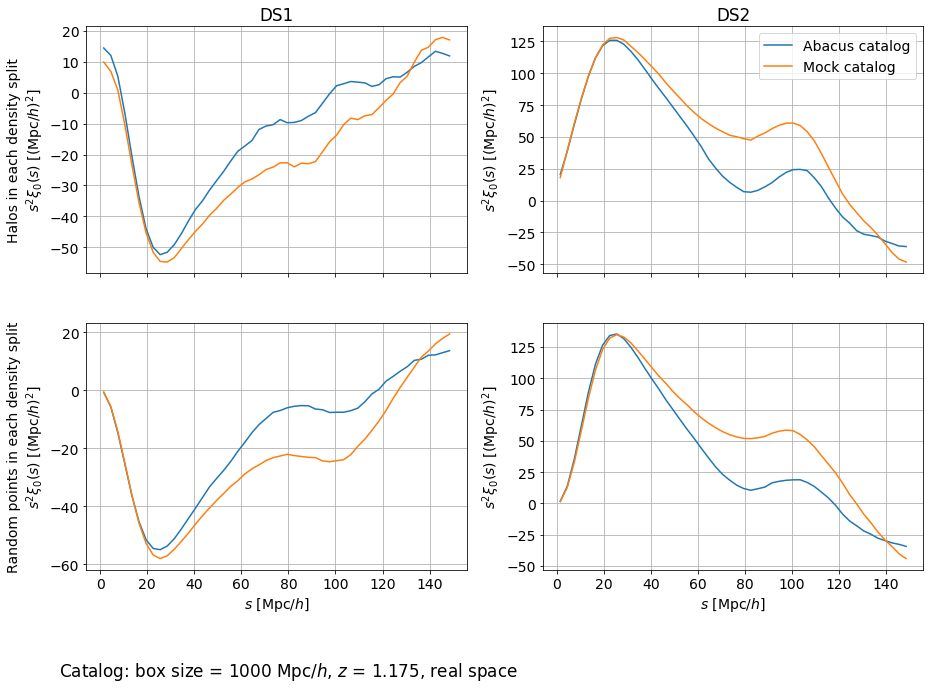

In [13]:
plt.rcParams["figure.figsize"] = (15, 10)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False)

for i in range(catalog_density.nsplits):
    
    axes[0][i].plot(s, s**2 * catalog_split_xiell_gg[i][0], label='Abacus catalog')
    axes[0][i].plot(s, s**2 * mock_split_xiell_gg[i][0], label='Mock catalog')
    axes[0][i].grid(True)

    axes[1][i].plot(s, s**2 * catalog_split_xiell_dg[i][0], label='Abacus catalog')
    axes[1][i].plot(s, s**2 * mock_split_xiell_dg[i][0], label='Mock catalog')
    axes[1][i].grid(True)

    axes[0][i].set_title('DS{}'.format(i+1))    
    axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel('Halos in each density split' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel('Random points in each density split' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, real space'.format(catalog.boxsize, catalog.redshift),
             ha='left', x=0.1, y=0)

axes[0][1].legend()
plt.show()

## Generate N mocks and compute all 2PCFs

In [14]:
def generate_N_densitySplit_CCF(catalog, nmocks, bias, cellsize, resampler, save_each=False, output_dir=''):
    results_gg = list()
    results_dg = list()
    
    for i in tqdm(range(nmocks)):
        mock_catalog = generate_mock(nmesh=catalog.boxsize/4, boxsize=catalog.boxsize, boxcenter=catalog.boxcenter, seed=i,
                                     cosmology=fiducial.AbacusSummitBase(), nbar=catalog.size/catalog.boxsize**3,
                                     z=catalog.redshift, bias=bias,
                                     save=save_each, output_dir=output_dir, name='mock'+str(i))
        
        mock_density = split_density(mock_catalog, cellsize, resampler, nsplits=2, save=False)
        mock_CCFs = compute_densitySplit_CCF(mock_density, edges, los='x')
        result_gg = mock_CCFs['gg']
        result_dg = mock_CCFs['dg']
        
        results_gg.append(result_gg)
        results_dg.append(result_dg)
        
    return results_gg, results_dg

In [ ]:
nmocks = 1000

results_gg, results_dg = generate_N_densitySplit_CCF(catalog, nmocks=nmocks, bias=bias, cellsize=cellsize, resampler=resampler, save_each=True, output_dir=output_dir)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
np.save(output_dir+catalog.name+'_1000_mocks_densitySplit_gg_CCF', results_gg)
np.save(output_dir+catalog.name+'_1000_mocks_densitySplit_dg_CCF', results_dg)

In [17]:
np.shape(results_gg[0])

(2,)

In [18]:
results_gg = np.load(output_dir+'1000_mocks_densitySplit_gg_CCF')
results_dg = np.load(output_dir+'1000_mocks_densitySplit_dg_CCF')

FileNotFoundError: [Errno 2] No such file or directory: '/feynman/work/dphp/mp270220/outputs/1000_mocks_densitySplit_gg_CCF'

## Compute covariance matrix

In [18]:
def get_poles(results, ells):
    nells = len(ells)
    n = len(results)
    nsplits = len(results[0])
    
    xiell = list()
    cov = list()
    
    for i in range(nsplits):
        results_poles = [np.ravel(res[i].get_corr(ells=ells, return_sep=False)) for res in results]
        poles = np.mean(results_poles, axis=0)
        xiell.append(poles.reshape((nells, len(poles)//nells)))
        cov.append(np.cov(results_poles, rowvar=False))

    return xiell, cov

In [19]:
ells = (0, 2)
nells = len(ells)

xiell_gg, cov_gg = get_poles(results_gg, ells)
xiell_dg, cov_dg = get_poles(results_dg, ells)

In [25]:
std_gg = [np.array_split(np.diag(cov_gg[i])**0.5, nells) for i in range(len(cov_gg))]
std_dg = [np.array_split(np.diag(cov_dg[i])**0.5, nells) for i in range(len(cov_gg))]

## Plot correlation function with error bars

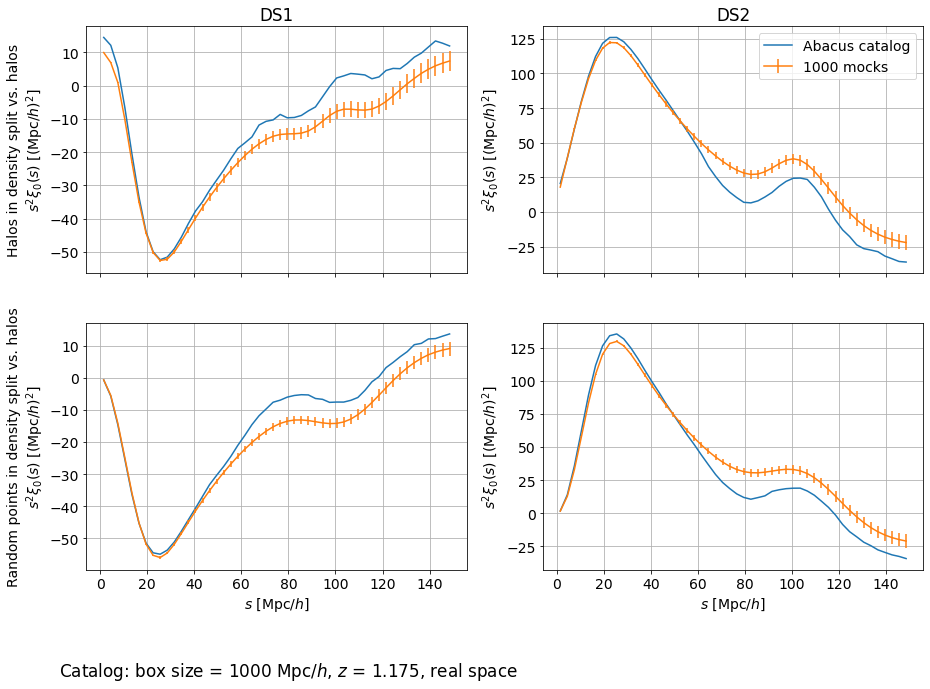

In [29]:
plt.rcParams["figure.figsize"] = (15, 10)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False)

for i in range(catalog_density.nsplits):
    
    axes[0][i].plot(s, s**2 * catalog_split_xiell_gg[i][0], label='Abacus catalog')
    axes[0][i].errorbar(s, s**2 * xiell_gg[i][0], s**2 * std_gg[i][0], fmt='-', label='{} mocks'.format(nmocks))
    axes[0][i].grid(True)

    axes[1][i].plot(s, s**2 * catalog_split_xiell_dg[i][0], label='Abacus catalog')
    axes[1][i].errorbar(s, s**2 * xiell_dg[i][0], s**2 * std_dg[i][0], fmt='-', label='{} mocks'.format(nmocks))
    axes[1][i].grid(True)

    axes[0][i].set_title('DS{}'.format(i+1))    
    axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel('Halos in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel('Random points in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, real space'.format(catalog.boxsize, catalog.redshift),
             ha='left', x=0.1, y=0)

axes[0][1].legend()
plt.show()